In [2]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from timeit import timeit
import sys
import os
import seaborn
import ast

from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import zscore


import threading


threading.stack_size(2**27)
sys.setrecursionlimit(10**8)


global DataFrequency

DataFrequency = '1T'

In [3]:
def vrRatio(X, ka):
    k = int(pd.Timedelta(ka) / '1T')
    log_prices = np.log(X)
    rets = np.diff(log_prices)
    T = len(rets)

    mu = np.mean(rets)
    sqr_demeaned_x = np.square(rets - mu)
    var_1 = np.sum(sqr_demeaned_x) / (T-1)
    rets_k = (log_prices - np.roll(log_prices,k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    vr = var_k / var_1
    return vr

global LossShift

LossShift = 250

def only_pnl_visualise_back(file_name, FOLDER, manyStrategies=False):

    PAIR_NAME = file_name.split('.')[0]
    inp_data = pd.read_csv(f'testData/{file_name}', index_col=1)
    # inp_data = pd.read_csv('testData/EURGBP.csv', index_col=0)
    inp_data.index = pd.to_datetime(inp_data.index)

    """EURGBP columns rename"""
    # inp_data.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, inplace=True)
    """DATABASE columns drop"""
    inp_data.drop(['instrument', 'volume', 'average', 'barCount'], axis=1, inplace=True)

    def create_grid(pam_grid_obj):
        CAP = 100_000
        slippage = 10
        BuyLossPercent = pam_grid_obj['BuyLossPercent']
        SellLossPercent = pam_grid_obj['BuyLossPercent']
        BuyTakePercent = pam_grid_obj['BuyTakePercent']
        SellTakePercent = pam_grid_obj['BuyTakePercent']
        MaxHold = pam_grid_obj['MaxHold']
        WindowRoll = pam_grid_obj['WindowRoll']
        Y_STD = pam_grid_obj['Y_STD']
        carrete_hyperParam = pam_grid_obj['caretteHYP']
        VR_PERCENT = 'None'
        # Массив параметров
        PARAMS = {'Capital': CAP,
                  'slippage': slippage,
                  'slippagePerCap': slippage / CAP,
                  'window_rolling': WindowRoll,
                  'Y_threshold': Y_STD,
                  'max_hold_period': MaxHold,
                  'stopLossesPercent': {
                      'BuyLossPercent': BuyLossPercent / 100,
                      'SellLossPercent': SellLossPercent / 100,
                  },
                  'takePercent': {
                      'SellTakePercent': BuyTakePercent / 100,
                      'BuyTakePercent': SellTakePercent / 100,
                  },
                  'shift_param': int(pd.Timedelta(WindowRoll) / pd.Timedelta(DataFrequency)),
                  'time_barrier_param': int(pd.Timedelta(MaxHold) / pd.Timedelta(DataFrequency)),
                  'variance_ratio_lookback': pd.Timedelta(WindowRoll) * 2,
                  'variance_ration_carette': pd.Timedelta(WindowRoll) * 2 / carrete_hyperParam,
                  'VR': VR_PERCENT
                  }
        del CAP, slippage, BuyLossPercent, SellLossPercent, BuyTakePercent, SellTakePercent, MaxHold, WindowRoll, Y_STD
        return PARAMS

    def calculate_max_drawdown(PNL_SERIES, dollars=True):
        """
        solution by Marco de Prado
        :param PNL_SERIES:
        :param dollars:
        :return:
        """
        dropout_df = PNL_SERIES.to_frame('pnl')
        dropout_df['hwm'] = dropout_df.expanding().max()
        df0 = dropout_df.groupby('hwm').min().reset_index()
        df0.columns = ['hwm', 'min']
        df0 = df0[df0['hwm'] > df0['min']]
        if dollars:
            dd = df0['hwm'] - df0['min']
        else:
            dd = df0['min'] / df0['hwm']

        return max(dd)

    def _estimator(data_frame, params_dict, show=False):
        try:
            DF_lines = []
            save_frame = data_frame.copy()
            # Считается параметр насколько нужно обрезать данные для адекватности сглаживания

            # Скользящее среднее
            data_frame.loc[:, 'rolling_mean'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).mean()

            # Скользящее отклонение
            data_frame.loc[:, 'rolling_std'] = data_frame.loc[:, 'close'].rolling(params_dict['window_rolling']).std()

            # Отсечение данных имеющих
            # data_frame.drop(data_frame.index[:params_dict['shift_param']], axis=0, inplace=True)

            # Верхний уровень BBand
            data_frame.loc[:, 'HighBBand'] = round(
                data_frame.loc[:, 'rolling_mean'] + ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),
                5)

            # Нижний уровень BBand
            data_frame.loc[:, 'LowBBand'] = round(
                data_frame.loc[:, 'rolling_mean'] - ((params_dict['Y_threshold'] / 100) * data_frame.loc[:, 'rolling_std']),
                5)

            # Добавление номера линии для удобства
            data_frame['line_number'] = range(1, data_frame.shape[0] + 1)

            dot_low_tuple = tuple(data_frame.low)
            dot_high_tuple = tuple(data_frame.high)
            dot_close_tuple = tuple(data_frame.close)
            LowBBand_tuple = tuple(data_frame.LowBBand)
            HighBBand_tuple = tuple(data_frame.HighBBand)
            rolling_mean = tuple(data_frame.rolling_mean)
            dot_open_tuple = tuple(data_frame.close)

            cycle_buffer = -10
            ISX = int(pd.Timedelta(params_dict['variance_ratio_lookback']) / '1T') * 3
            if show:
                tqdm_bar = tqdm(total=data_frame.shape[0])

            while ISX < (data_frame.shape[0] / 1.1) and (cycle_buffer != ISX):

                openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                         LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                         arrow_index=ISX, openParams=params_dict, correct_borders=[], opens=dot_open_tuple, recursion_limiter=0)
                while type(openLogic) != dict:
                    openLogic = OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                             LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                             arrow_index=openLogic, openParams=params_dict, correct_borders=[],
                                             opens=dot_open_tuple, recursion_limiter=0)

                openLogic['open_time'] = data_frame.index[openLogic['open_index']]
                closeLogic = HoldingPosition(open_logic=openLogic, dot_close_tuple=dot_close_tuple,
                                             dot_high_tuple=dot_high_tuple, dot_low_tuple=dot_low_tuple,
                                             holdParams=params_dict, arrow_index=openLogic['open_index'] + 1,
                                             time_border_counter=0, rolling_mean=rolling_mean)

                closeLogic['close_time'] = data_frame.index[closeLogic['close_index']]
                #summary_dict = dict(openLogic.copy()).update(closeLogic)
                summary_dict = {**openLogic, **closeLogic}
                DF_lines.append(summary_dict)

                cycle_buffer = ISX
                ISX = closeLogic['close_index']
                if show:
                    tqdm_bar.update(ISX - tqdm_bar.last_print_n)

            dfResults = pd.DataFrame(DF_lines)
            dfResults["profit"] = dfResults["position"] * (dfResults["close_price"] - dfResults["open_price"]) - params_dict["slippage"] if (dfResults["type_operation"] == 'BUY').bool else abs(dfResults["position"]) * (dfResults["open_price"] - dfResults["close_price"]) - params_dict["slippage"]
            dfResults.index = dfResults.close_time
            pnl_series = dfResults["profit"].cumsum()

            optimizePar = round(pnl_series[-1] / calculate_max_drawdown(pnl_series + params_dict['Capital']), 4)
            params_dict_opt = params_dict.copy()
            params_dict_opt['result'] = optimizePar
            params_dict_opt['total_pnl'] = pnl_series.iloc[-1]

            return [dfResults, data_frame, optimizePar, params_dict_opt]
        except KeyError:
            optimizePar = -1
            params_dict_opt = params_dict.copy()
            params_dict_opt['total_pnl'] = -10000
            params_dict_opt['result'] = optimizePar
            return [optimizePar, params_dict_opt]


    def OpenPosition(dot_low_tuple, dot_high_tuple, LowBBand_tuple, HighBBand_tuple, arrow_index, openParams,
                     correct_borders, opens, recursion_limiter):
        """
        Проверяет возможно ли открыть сделку. В случае возможности возвращает информацию об открытой сделки
        :param current_dot:
        :param arrow_index:
        :return:
        """
        # Задается вид словаря описывающего информацию об открытии сделки
        ret_dict = {'type_operation': None,
                    'position': None,
                    'open_price': None,
                    'open_index': None,
                    'stop_loss_border': None,
                    'take_profit_border': None
                    }
        if arrow_index > len(dot_low_tuple):
            return 'InCorrectData'
        if recursion_limiter > 10_000:
            return arrow_index

        # Проверка о пересечении нижней границы
        if (dot_low_tuple[arrow_index] < LowBBand_tuple[arrow_index]):
                ret_dict['type_operation'] = 'BUY'
                ret_dict['position'] = 1 * (openParams['Capital'] / LowBBand_tuple[arrow_index])
                ret_dict['open_price'] = LowBBand_tuple[arrow_index]
                ret_dict['open_index'] = arrow_index
                ret_dict['stop_loss_border'] = round(LowBBand_tuple[arrow_index] * (1 - openParams['stopLossesPercent']['BuyLossPercent']), 5)
                ret_dict['take_profit_border'] = round(LowBBand_tuple[arrow_index] * (1 + openParams['takePercent']['BuyTakePercent']), 5)
                return ret_dict

        # Проверка о пересечении верхней границы
        if (dot_high_tuple[arrow_index] > HighBBand_tuple[arrow_index]):
                ret_dict['type_operation'] = 'SELL'
                ret_dict['position'] = -1 * (openParams['Capital'] / HighBBand_tuple[arrow_index])
                ret_dict['open_price'] = HighBBand_tuple[arrow_index]
                ret_dict['open_index'] = arrow_index

                ret_dict['stop_loss_border'] = round(HighBBand_tuple[arrow_index] * (1 + openParams['stopLossesPercent']['SellLossPercent']), 5)
                ret_dict['take_profit_border'] = round(HighBBand_tuple[arrow_index] * (1 - openParams['takePercent']['SellTakePercent']), 5)
                return ret_dict

        else:
            return OpenPosition(dot_low_tuple=dot_low_tuple, dot_high_tuple=dot_high_tuple,
                                LowBBand_tuple=LowBBand_tuple, HighBBand_tuple=HighBBand_tuple,
                                arrow_index=arrow_index + 1, openParams=openParams, correct_borders=correct_borders, opens=opens, recursion_limiter=recursion_limiter+1)



    def HoldingPosition(open_logic, dot_close_tuple, dot_high_tuple, dot_low_tuple, holdParams, arrow_index,
                        time_border_counter, rolling_mean):
        if open_logic['type_operation'] == 'BUY':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index],
                        'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'],
                        'close_index': arrow_index + LossShift}
            elif dot_high_tuple[arrow_index] >= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'],
                        'close_index': arrow_index}
            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple,
                                       dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1, rolling_mean=rolling_mean)

        if open_logic['type_operation'] == 'SELL':
            if time_border_counter - 1 > holdParams['time_barrier_param']:
                return {'type_holding': 'endPeriod', 'close_price': dot_close_tuple[arrow_index],
                        'close_index': arrow_index}
            elif dot_low_tuple[arrow_index] <= open_logic['take_profit_border']:
                return {'type_holding': 'takeProfit', 'close_price': open_logic['take_profit_border'],
                        'close_index': arrow_index}
            elif dot_high_tuple[arrow_index] >= open_logic['stop_loss_border']:
                return {'type_holding': 'stopLoss', 'close_price': open_logic['stop_loss_border'],
                        'close_index': arrow_index + LossShift}

            else:
                return HoldingPosition(open_logic=open_logic, dot_close_tuple=dot_close_tuple,
                                       dot_high_tuple=dot_high_tuple,
                                       dot_low_tuple=dot_low_tuple, holdParams=holdParams,
                                       arrow_index=arrow_index + 1, time_border_counter=time_border_counter + 1, rolling_mean=rolling_mean)


    def plotter(test_df, qqq):
        plt.figure(figsize=(16,16))

        ax1 = plt.subplot(4,1,1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        ax2 = plt.subplot(4,1,2, sharex=ax1)
        ax2.set_title('Bbands')
        plt.plot(qqq.open, label='open', alpha=.5)
        plt.plot(qqq.high, label='high', alpha=.7, color='red')
        plt.plot(qqq.low, label='close', alpha=.7, color='yellow')
        plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='blue')
        plt.legend(loc='lower right')
        ax3 = plt.subplot(4,1,3, sharex=ax1)
        ax3.set_title('trades histogram')
        for _ in range(test_df.shape[0]):
            if test_df.iloc[_].type_operation == 'BUY':
                plt.axvline(x=test_df.iloc[_].open_time, color='green', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='green', alpha=.6, linewidth=.5)
            if test_df.iloc[_].type_operation == 'SELL':
                plt.axvline(x=test_df.iloc[_].open_time, color='red', alpha=.6, linewidth=.5)
                plt.axvline(x=test_df.iloc[_].close_time, color='red', alpha=.6, linewidth=.5)
            plt.hlines(xmin=test_df.iloc[_].open_time, xmax=test_df.iloc[_].close_time, y=test_df.open_price[_], color='black', linestyles='-')
        ax4 = plt.subplot(4,1,4, sharex=ax1)

        plt.show()

    def lightPlotter(test_df, qqq, final=False, show=False):
        plt.figure(figsize=(10,7))
        if not final:
            plt.title('InSample')
        if final:
            plt.title('OutOfSample')
        ax1 = plt.subplot(1, 1, 1)
        ax1.set_title('pnl graph')
        plt.step(test_df.open_time, test_df.profit.cumsum().values)
        # ax2 = plt.subplot(2,1,2, sharex=ax1)
        # ax2.set_title('Bbands')
        # plt.plot(qqq.open, label='open', alpha=.5)
        # plt.plot(qqq.HighBBand, label='HighBand', alpha=.6, color='blue')
        # plt.plot(qqq.rolling_mean, label='MovingAverage', alpha=1, color='red')
        # plt.plot(qqq.LowBBand, label='LowBand', alpha=.6, color='yellow')
        # plt.legend(loc='lower right')
        if not show:
            plt.close()

    """WAY TO DELETE HOLIDAYS"""
    inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
    inp_data.index = inp_data.beautiful_time
    if not manyStrategies:
        plt.figure(figsize=(13,7))
        plt.title('RESAMPLED')
        plt.plot(inp_data.copy().open)
        plt.show()
    # PARAMS_DF = pd.read_csv(f"backTEST/{PAIR_NAME}/result_{file_name}", index_col=0)
    # PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    # PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    # PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss']]
    # PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    # optimal = PARAMS_DF.iloc[0]

    PARAMS_DF = pd.read_csv(f"{FOLDER}/{PAIR_NAME}/result_{file_name}", index_col=0)
    print(f"Total test strategies for optimizing: {PARAMS_DF.shape[0]}")
    print(f"Average result: {PARAMS_DF.result.mean()}")
    print(f"Result > 0: {PARAMS_DF[PARAMS_DF.result > 0].shape}")
    print(f"max: {PARAMS_DF.result.max()}")
    PARAMS_DF["TakeProfit"] = PARAMS_DF.takePercent.aggregate(lambda x: ast.literal_eval(x)['SellTakePercent'])
    PARAMS_DF["StopLoss"] = PARAMS_DF.stopLossesPercent.aggregate(lambda x: ast.literal_eval(x)['BuyLossPercent'])
    PARAMS_DF = PARAMS_DF[['window_rolling', 'Y_threshold', 'max_hold_period', 'result', 'TakeProfit', 'StopLoss', 'total_pnl', 'variance_ratio_lookback', 'variance_ration_carette']]
    abs_Z_scores = np.abs(zscore(PARAMS_DF.result))
    filtered = (abs_Z_scores < 25)
    print('OLD:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF[filtered]
    PARAMS_DF.reset_index(inplace=True, drop=True)
    print('NEW:', PARAMS_DF.shape)
    PARAMS_DF = PARAMS_DF.sort_values(by='result', ascending=False)
    if not manyStrategies:
        optimal = PARAMS_DF.iloc[0]
        optimal['caretteHYP'] = int((pd.Timedelta(optimal.window_rolling) * 2)/ (pd.Timedelta(optimal.variance_ration_carette) - pd.Timedelta('1T')))

        print(optimal)
        optParams = {
            "BuyLossPercent": optimal.StopLoss * 100,
            #"SellLossPercent": [20, 30, 40],
            "BuyTakePercent": optimal.TakeProfit * 100,
            #"SellTakePercent": [20, 30, 40],
            # "MaxHold": optimal.max_hold_period,
            "MaxHold": optimal.max_hold_period,
            "WindowRoll": optimal.window_rolling,
            "Y_STD": optimal.Y_threshold,
            'caretteHYP': optimal.caretteHYP
                  }


        print('OPTIMAL_PARAMS:\n', optParams)
        # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2019-01-01': '2020-01-01'], params_dict=create_grid(dict(optParams)), show=True)
        df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2018-10-01': '2019-09-15'], params_dict=create_grid(dict(optParams)), show=True)
        # plotter(df, preprocessed_data)
        lightPlotter(df, preprocessed_data, show=True)
        print('INSAMPLE')
        print(f"""PNL/DRAWDOWN:{optimizePar}
        DRAWDOWN{round(df.profit.cumsum().iloc[-1] / optimizePar), 3}
        Total trades: {df.shape[0]}
        Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
        Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        """)

        # with open(f'backTEST/{PAIR_NAME}/best_InSample_stat.txt', 'w') as file:
        #     file.writelines(f"""
        #         PNL/DRAWDOWN:{optimizePar}
        #         Total trades:, {df.shape[0]}
        #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
        #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        #         """)

        # df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-01'], params_dict=create_grid(dict(optParams)), show=True)
        df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-15'], params_dict=create_grid(dict(optParams)), show=True)
        # plotter(df, preprocessed_data)
        lightPlotter(df, preprocessed_data, final=True, show=True)
        print('OUTOFSAMPLE')
        print(f"""PNL/DRAWDOWN:{optimizePar}
        DRAWDOWN: {round(df.profit.cumsum().iloc[-1] / optimizePar), 3}
        Total trades: {df.shape[0]}
        Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
        Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        """)

        # with open(f'backTEST/{PAIR_NAME}/outsample_stat.txt', 'w') as file:
        #     file.writelines(f"""
        #         PNL/DRAWDOWN:{optimizePar}
        #         Total trades:, {df.shape[0]}
        #         Total pnl, {round(df.profit.cumsum().iloc[-1], 3)}
        #         Positive trades:, {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
        #         Negative trades:, {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
        #         Long trades:, {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
        #         Short trades:, {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
        #         StopLoss closes:, {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
        #         TakeProfit closes:, {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
        #         endPeriod closes:, {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
        #         """)

        df["own_time"] = df.close_time - df.open_time
        plt.figure(figsize=(12,9))
        plt.title('MarkOut')
        ax = plt.subplot(1,1,1)
        df.groupby(by='own_time').profit.mean().plot(marker='o', ax=ax)
        plt.legend(loc='lower left')
        plt.show()
        return df
    if manyStrategies:
        RES = list()
        SHOW = True
        for arrow in tqdm(range(30)):
            optimal = PARAMS_DF.iloc[arrow]
            optimal['caretteHYP'] = int((pd.Timedelta(optimal.window_rolling) * 2)/ (pd.Timedelta(optimal.variance_ration_carette) - pd.Timedelta('1T')))
            if SHOW:
                print(optimal)
            optParams = {
                "BuyLossPercent": optimal.StopLoss * 100,
                #"SellLossPercent": [20, 30, 40],
                "BuyTakePercent": optimal.TakeProfit * 100,
                #"SellTakePercent": [20, 30, 40],
                # "MaxHold": optimal.max_hold_period,
                "MaxHold": optimal.max_hold_period,
                "WindowRoll": optimal.window_rolling,
                "Y_STD": optimal.Y_threshold,
                'caretteHYP': optimal.caretteHYP
                      }

            df, preprocessed_data, optimizePar, total_df = _estimator(data_frame=inp_data.copy().loc['2020-01-01': '2021-01-15'], params_dict=create_grid(dict(optParams)), show=False)
            if SHOW:
                print('OUTOFSAMPLE')
                print(f"""  PNL/DRAWDOWN:{optimizePar}
                DRAWDOWN: {round(df.profit.cumsum().iloc[-1] / optimizePar), 3}
                Total trades: {df.shape[0]}
                Total pnl {round(df.profit.cumsum().iloc[-1], 3)}
                Positive trades: {round(df[df.profit > 0].shape[0] / df.shape[0], 3)}
                Negative trades: {round(df[df.profit < 0].shape[0] / df.shape[0], 3)}
                Long trades: {round(df[df.type_operation == 'BUY'].shape[0] / df.shape[0], 3)}
                Short trades: {round(df[df.type_operation == 'SELL'].shape[0] / df.shape[0], 3)}
                StopLoss closes: {round(df[df.type_holding == 'stopLoss'].shape[0] / df.shape[0], 3)}
                TakeProfit closes: {round(df[df.type_holding == 'takeProfit'].shape[0] / df.shape[0], 3)}
                endPeriod closes: {round(df[df.type_holding == 'endPeriod'].shape[0] / df.shape[0], 3)}
                """)
                print('=' * 90)
            RES.append(round(df.profit.cumsum().iloc[-1], 3))
        return RES

/var/folders/_r/6hvfrncn0gb3rk22vwnq62gh0000gn/T/ipykernel_2896/646345374.py:308: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  inp_data.beautiful_time = pd.date_range(pd.Timestamp(inp_data.index.min()), pd.Timestamp(inp_data.index.min()) + pd.Timedelta(f"{inp_data.shape[0] - 1}T"), freq='1T')
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Users/molozey/Desktop/algo/venv/lib/python3.9/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

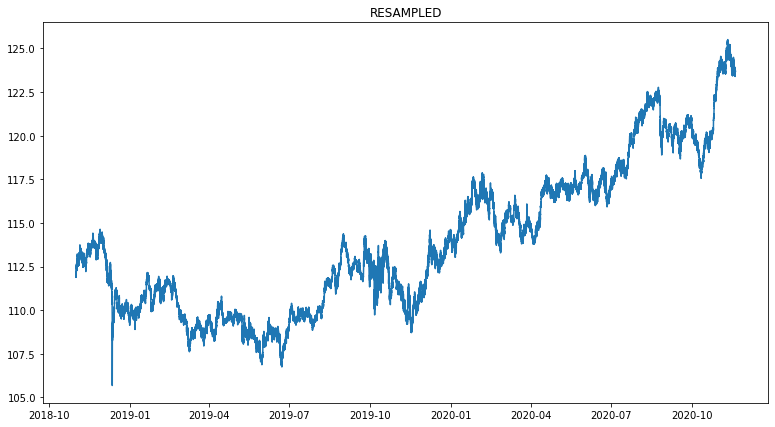

Total test strategies for optimizing: 8000
Average result: -0.4400758
Result > 0: (1406, 14)
max: 8.156
OLD: (8000, 9)
NEW: (8000, 9)
window_rolling                        160T
Y_threshold                         281.11
max_hold_period                       784T
result                               8.156
TakeProfit                            0.01
StopLoss                             0.009
total_pnl                     14304.286605
variance_ratio_lookback    0 days 05:20:00
variance_ration_carette    0 days 00:32:00
caretteHYP                              10
Name: 1853, dtype: object
OPTIMAL_PARAMS:
 {'BuyLossPercent': 0.9000000000000001, 'BuyTakePercent': 1.0, 'MaxHold': '784T', 'WindowRoll': '160T', 'Y_STD': 281.11, 'caretteHYP': 10}
INSAMPLE
PNL/DRAWDOWN:8.156
        DRAWDOWN(1754, 3)
        Total trades: 457
        Total pnl 14304.287
        Positive trades: 0.547
        Negative trades: 0.453
        Long trades: 0.501
        Short trades: 0.499
        StopLoss closes: 0.004

  0%|          | 0/459345 [00:00<?, ?it/s]

  0%|          | 0/465466 [00:00<?, ?it/s]

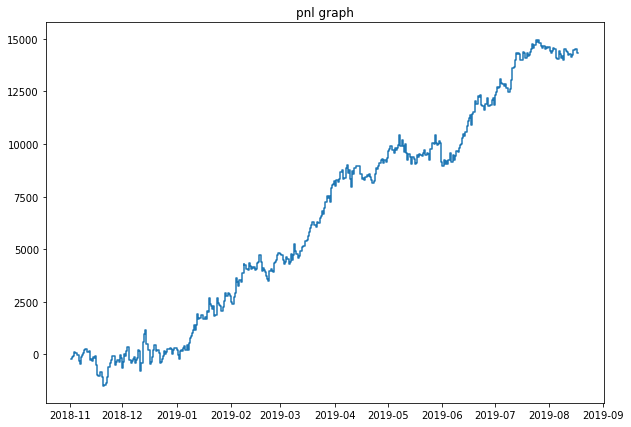

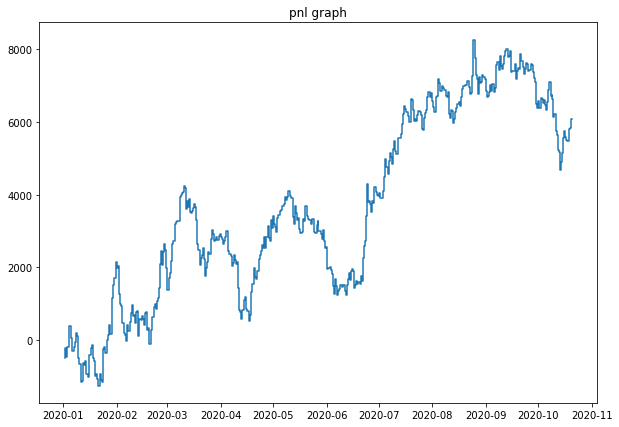

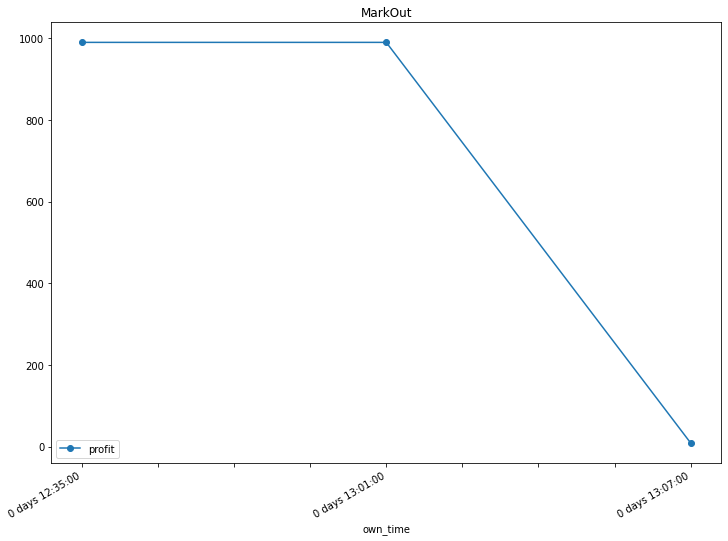

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

In [12]:
df = only_pnl_visualise_back('CHFJPY.csv', FOLDER='backTEST', manyStrategies=False)

import scipy.stats as st
# returns confidence interval of mean
def confIntMean(a, conf=0.95):
  mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
  return mean - m*sem, mean + m*sem
confIntMean(df)

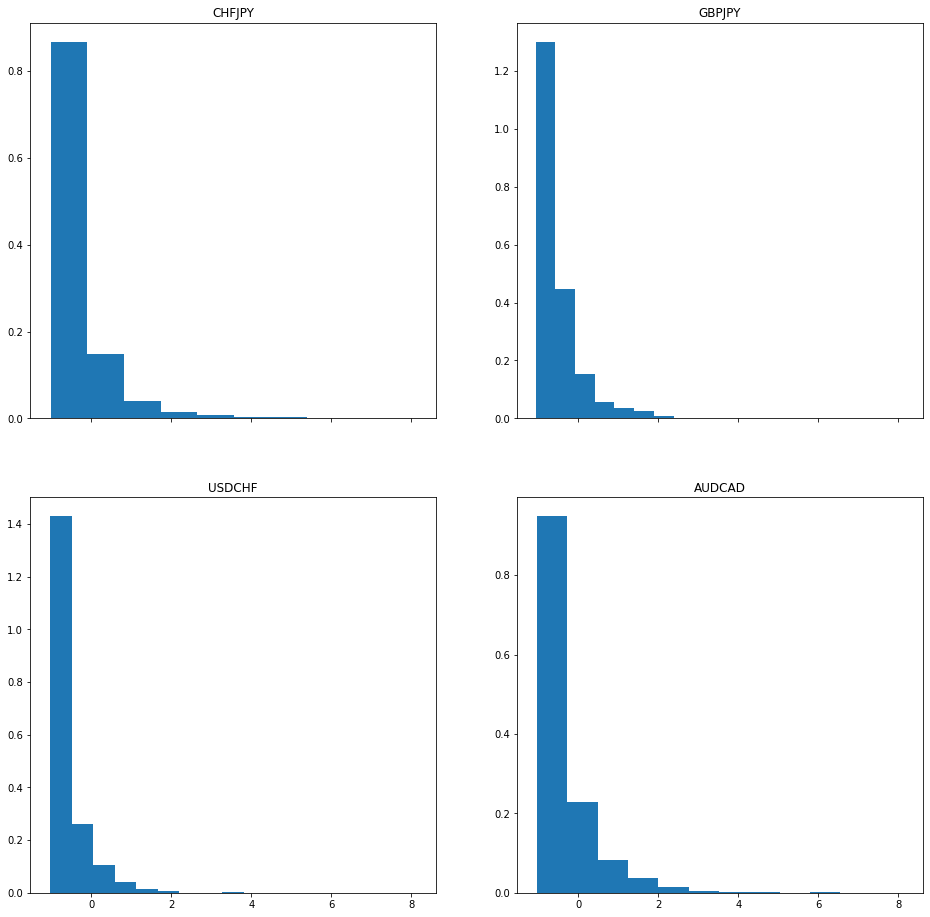

In [11]:
import glob
fig, ax = plt.subplots(len(glob.glob('backTESTclean/*')) // 2, 2, sharex=True, figsize=(16, 16))

for i, pair in enumerate(glob.glob('backTESTclean/*')):
    ax[i // 2, i % 2].set_title(f"{pair.split('/')[1]}")
    ax[i // 2, i % 2].hist(pd.read_csv(f"{pair}/result_{pair.split('/')[1]}.csv", index_col=0).result, density=True)

(array([6.426e+03, 1.050e+03, 3.200e+02, 9.200e+01, 6.700e+01, 2.000e+01,
        1.100e+01, 8.000e+00, 0.000e+00, 6.000e+00]),
 array([-1.0181 , -0.10069,  0.81672,  1.73413,  2.65154,  3.56895,
         4.48636,  5.40377,  6.32118,  7.23859,  8.156  ]),
 <BarContainer object of 10 artists>)

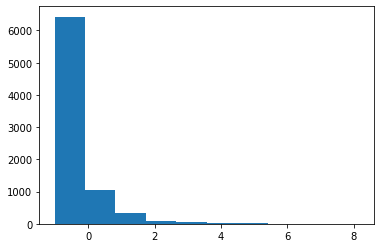

In [13]:
plt.hist(pd.read_csv('backTEST/CHFJPY/result_CHFJPY.csv', index_col=0).result)